# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd
from collections import defaultdict

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
    - [Finger Load Comparison](#finger-load)
    - [Which Rows do Keys Gravitate to](#rows-gravitation)
    - [Bigrams vs Position Penalties](#bigram-position-chart)
- [Test your layout here](#your-layout)
    - [Export any layout to Linux XKB](#export-to-xkb)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt', types={'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'})

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м   159  ¶  м  -  c  0.000174
1        мо  3241  м  о  c  v  0.003554
2        ож  1890  о  ж  v  c  0.002073
3        же  2825  ж  е  c  v  0.003098
4        ет  5188  е  т  v  c  0.005689
...     ...   ... .. .. .. ..       ...
2682     oн     1  o  н  -  c  0.000001
2683     нa     1  н  a  c  -  0.000001
2684     еp     1  е  p  v  -  0.000001
2685     yг     1  y  г  -  c  0.000001
2686     гy     1  г  y  c  -  0.000001

[2687 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   71951
е   58480
а   54526
и   44490
т   42842
н   34441
р   30361
л   28373
с   26001
в   19409
к   17751
м   17189
д   16076
у   15812
ы   13770
ь   13741
я   12830
з    8539
й    8514
г    8425
б    7297
ч    7212
ж    5906
х    5796
п    5654
ю    4653
ш    4591
ц    2550
щ    2470
ё    1222
ф     938
ъ     273
э     268

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

freq_out     freq_in      outer   frequency     outerness
ъ   2.949778    0.000000  -2.949778    2.949778 -10000.000000
ы  18.970692    0.032897 -18.937795   19.003589  -9965.377957
ь   9.880112    0.021931  -9.858180    9.902043  -9955.703212
а  53.874572    7.050957 -46.823615   60.925529  -7685.385169
о  44.959443    9.715626 -35.243817   54.675069  -6446.048937
у  16.042845    4.759122 -11.283724   20.801967  -5424.354244
и  71.331995   26.229997 -45.101998   97.561992  -4622.906598
е  21.383150  103.088714  81.705564  124.471864   6564.179367
я   5.647345   54.346098  48.698753   59.993443   8117.346006
э   0.032897    1.447475   1.414578    1.480372   9555.555556
ю   0.394766   35.912726  35.517960   36.307492   9782.543038
ё   0.000000    2.862052   2.862052    2.862052  10000.000000

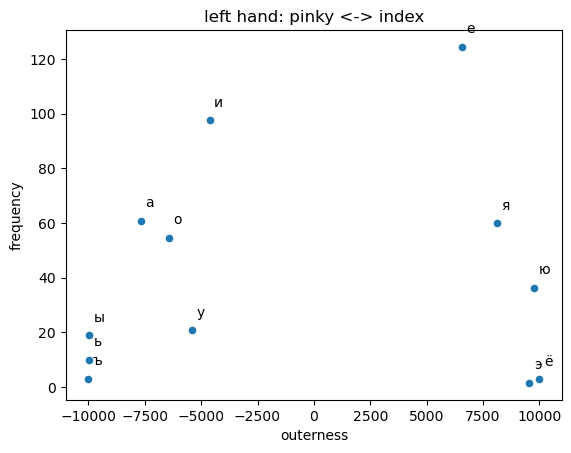

In [5]:
CORP.display_outerness("(t1 == 'v') & (t2 == 'v')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.701806    5.044230   -4.342424    5.746036 -7557.251908
ц     1.173332    8.410706   -7.237374    9.584037 -7551.487414
л    21.503773   82.396404  -60.892631  103.900177 -5860.686016
р    51.900743  165.768757 -113.868014  217.669500 -5231.234257
н    62.559420  156.919423  -94.360002  219.478843 -4299.275543
т   103.461548  183.763500  -80.301952  287.225048 -2795.785133
к    43.413277   74.281773  -30.868496  117.695050 -2622.752259
м    21.624396   23.642088   -2.017692   45.266483  -445.736434
ф     2.620807    2.686601   -0.065794    5.307407  -123.966942
в    67.439165   61.660232    5.778933  129.099397   447.634418
ш    13.136930   10.176186    2.960744   23.313116  1269.990593
д    53.710086   40.200322   13.509764   93.910408  1438.580103
х     8.224288    5.680242    2.544047   13.904530  1829.652997
г    27.589746   11.963598   15.626148   39.553344  3950.651511
ж    21.942401    7.928214   14.014187   29.870615  4691.629956
с   241.541868   86.333097  155.208771  327.874964  4733.779264
ч    39.970042   11.042478   28.927564   51.012520  5670.679278
п    81.223072   21.536670   59.686402  102.759742  5808.344894
б    30.276347    5.680242   24.596105   35.956589  6840.500152
з    55.508464    4.210836   51.297628   59.719300  8589.790672
й    19.815052    0.010966   19.804086   19.826018  9988.938053

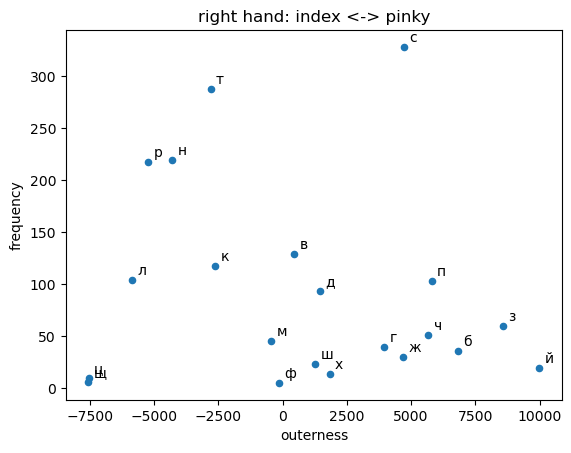

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
753222 4222357
621123 43112346
 10002 2000124
 21114 411123
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
7532226 622235
6321134 431123
 210002 200012
 311114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32букваП': r'''    
ъ12345 67890-=
→фуыхэ жшвкчзщ/
 поией ,ртнсд¶
 ьаёяю цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест38': r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест39': r'''
ъ12345 67890-=
→фёыхэ шмвкчйц
 аиое, зртнсг¶
 щьуяю жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    

'тест40': r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.9316
key """ repeated: 2
key "?" repeated: 2
layout usphonetic: 3.0954
layout rusdvorak: 1.7072
key ":" repeated: 2
layout диктор: 1.4334
layout зубачёв: 1.3782
key "." repeated: 2
layout скоропис: 1.4089
key """ repeated: 3
key ":" repeated: 2
key ";" repeated: 2
layout ант: 1.6286
layout ugnvs: 1.9787
layout леонов: 1.2538
layout леонов2: 1.1735
layout леонов3: 1.3567
layout тест1: 2.6568
layout тест2: 2.3453
layout тест3: 2.0444
layout тест4: 1.8717
layout тест5: 1.7126
layout тест6: 1.7855
layout тест7: 1.8043
layout тест8: 1.7417
layout тест9: 1.7502
layout тест10: 1.593
layout тест11: 1.6193
layout тест12: 1.5518
layout тест13: 1.5665
layout тест14: 1.5323
layout тест15: 1.4516
layout тест16: 1.4445
layout тест17: 1.4014
layout тест18: 1.411
layout тест19: 1.4384
layout тест20: 1.4377
layout тест21: 1.4006
layout тест22: 1.4006
layout тест23: 1.3782
layout тест24: 1.3264
layout тест25: 1.3787
layout ино1: 1.2734
layout тест26: 1.3243
layout тест27: 1.309
layout и

# Final Standings <a name="standings">

In [12]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест39', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   1.077 | Alien #2, many counterparts on AltGr   |
| тест39     |   1.252 | Best and currently in use on my laptop |
| леонов     |   1.254 | Leonov                                 |
| ино1       |   1.273 | Alien #1, rare letters on AltGr        |
| зубачёв    |   1.378 | Zubachov                               |
| скоропис   |   1.409 | Skoropis                               |
| диктор     |   1.433 | Dictor                                 |
| тест10     |   1.593 | First optimized after hand testing     |
| ант        |   1.629 | ANT                                    |
| rusdvorak  |   1.707 | Dvorak translit                        |
| тест9      |   1.75  | First hand-tested                      |
| ugnvs      |   1.979 | UGNVS                                  |
| тест2      |   2.345 | My first Dvorak analog  

## Finger Load Comparison <a name='finger-load'/>

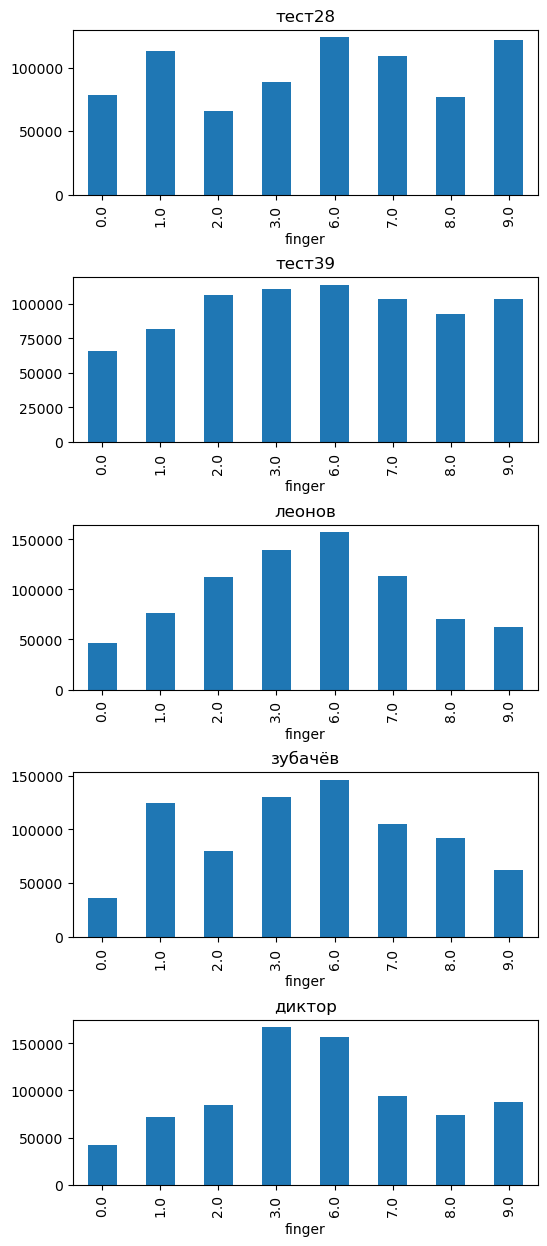

In [13]:
keys = ('тест28', 'тест39', 'леонов', 'зубачёв', 'диктор')
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(keys), 1, figsize=(6, 15))
plt.subplots_adjust(hspace=.5)
dfs = []
for k, ax in zip(keys, axs):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d.plot.bar(ax=ax, title=k, legend=False)

## Which Rows do Keys Gravitate to <a name='rows-gravitation'>
    
In this chart, we show how many bigrams do letters have with rows 1-3 (main key rows). If a key in bottom row has most bigrams in bottom or middle row, it's fine in that position. This chart actually shows that almost all letters are in their best places.
    
note: This calculation excludes combos with keys on another hand, and with the key itself (НН is quite popular that it distorts the stats significantly).

Letter В (v) may gain a little bit in the bottom row, but letters in that row will loose more.

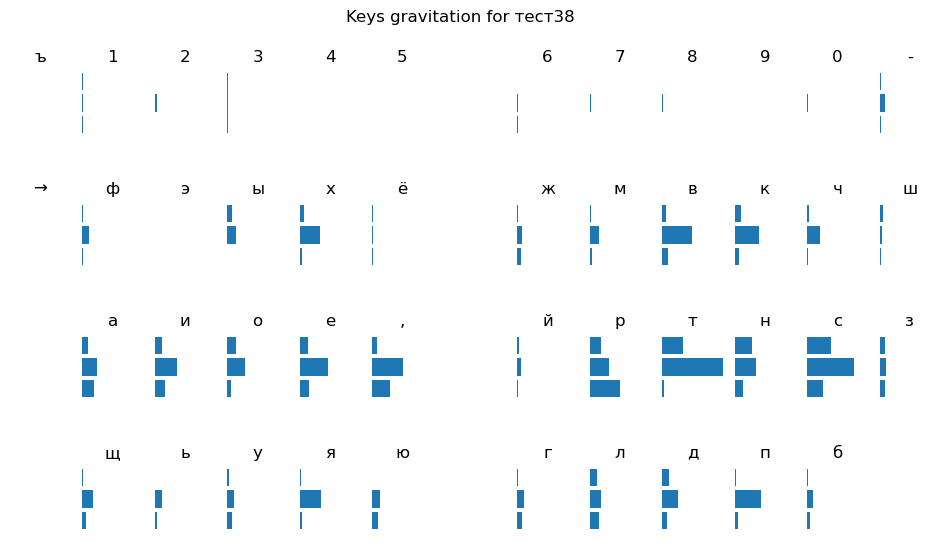

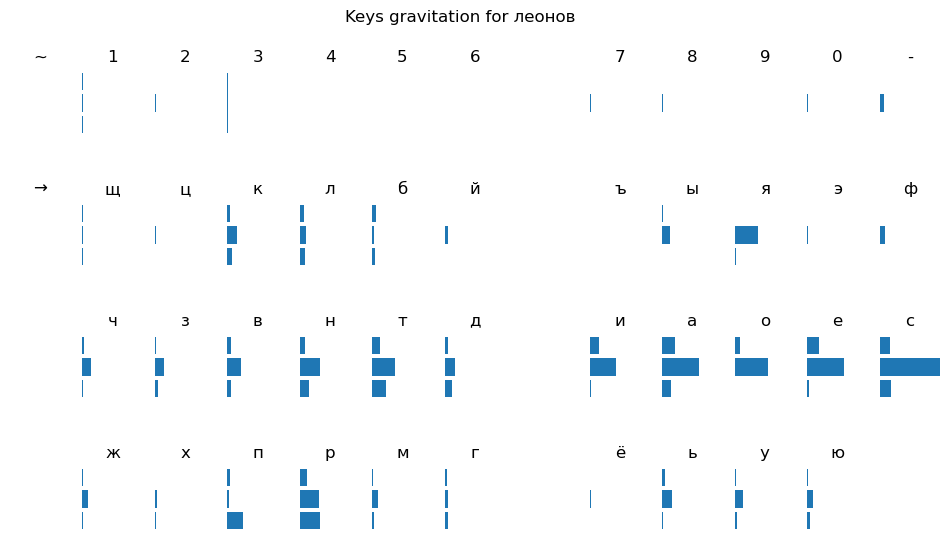

In [14]:
results['тест38'].display('rows')
results['леонов'].display('rows')

# Bigrams vs Position Penalties <a name='bigram-position-chart'/>

### Theoretical minimal score

This calculation shows how low could the score be if we put keys ordered by frequencies, and there were no bigrams penalties:

In [15]:
pos_penalties = [r['penalty'] for r in STANDARD_KBD.keymap.values()]
pos_penalties.sort()
freqs = CORP.bigrams.groupby('l2').agg({'freq': 'sum'}).sort_values('freq', ascending=False).values
min_score = sum(a * b for a, b in zip(freqs, pos_penalties))[0]
min_score

0.6772898886212033

name    pos  bigram
0       йцукен  1.511   1.420
1   usphonetic  1.452   1.644
2    rusdvorak  1.041   0.667
3       диктор  0.935   0.498
4      зубачёв  0.830   0.548
5          ант  1.064   0.564
6        ugnvs  0.909   1.070
7       леонов  0.777   0.477
8        тест1  1.512   1.145
18      тест11  1.170   0.450
34      тест27  0.920   0.389
46      тест38  0.821   0.440
47      тест39  0.813   0.439

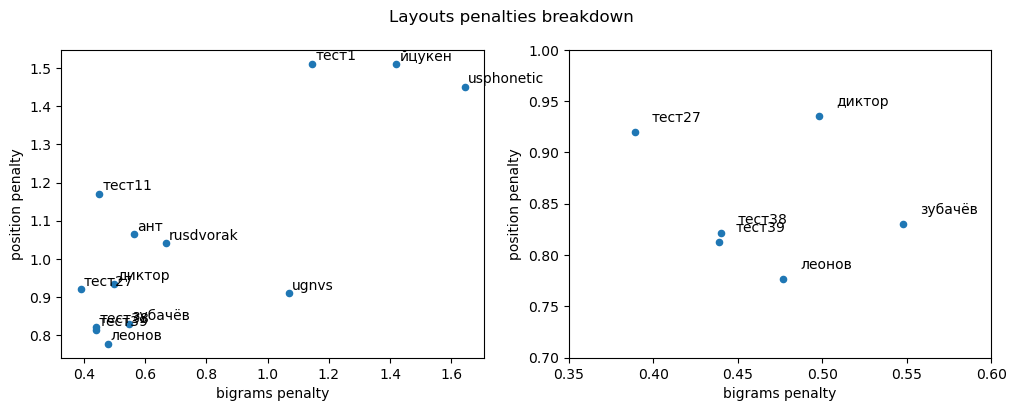

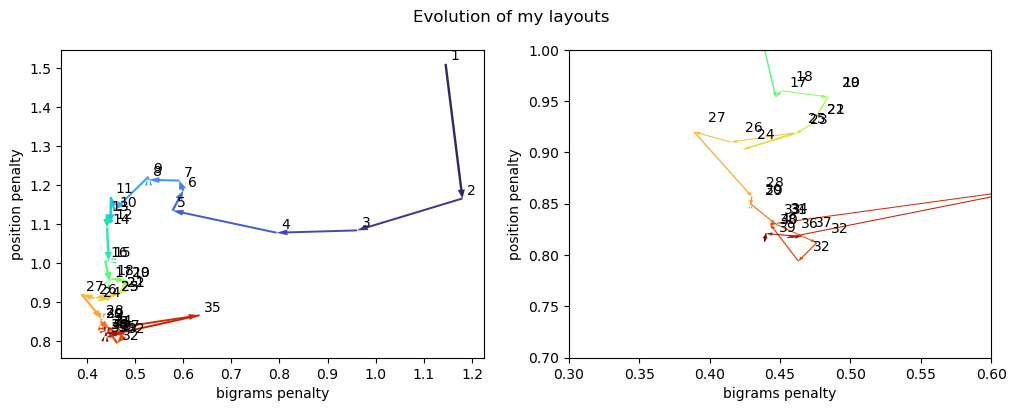

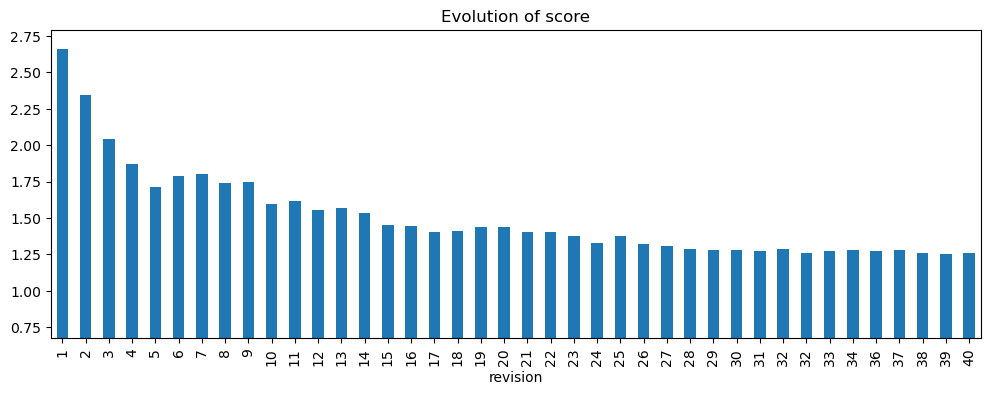

In [43]:
dd = []
for k, v in results.items():
#    if k.startswith('тест') and not k.startswith('тест37'): continue
    if k.startswith('леонов') and not k == 'леонов': continue
    if k.startswith('ино'): continue
    if k.startswith('скоропис'): continue
    b = results[k].bigrams
    dd.append({
        'name': k, 
        'pos': round((b.price_l2 * b.num).sum() / b.num.sum(), 3),
        'bigram': round((b.price_di * b.num).sum() / b.num.sum(), 3)
    })
    
df2 = pd.DataFrame(dd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
lims = (0.6, 1.0)
# selecting layouts to display their scores
df3 = df2[~df2.name.str.startswith('тест') | df2.name.isin(['тест39', 'тест38', 'тест27', 'тест1', 'тест11'])]
for ax in (ax1, ax2):
    df3.plot.scatter(x='bigram', y='pos', ax=ax)
    for i, r in df3.iterrows():
        ax.annotate(r['name'], (r.bigram + .01, r.pos + .01))

    for a in (ax1, ax2):
        a.set_xlabel('bigrams penalty')
        a.set_ylabel('position penalty')

ax2.set_xlim(0.35, 0.6)
ax2.set_ylim(0.7, 1.0)
        
fig.suptitle('Layouts penalties breakdown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Evolution of my layouts')

import re
df4 = df2[df2.name.apply(lambda k: re.match(r'тест(\d+)', k) is not None)].copy()
df4['revision'] = df4.name.apply(lambda k: int(re.match(r'тест(\d+)', k).groups()[0]))
df4.sort_values('revision', inplace=True)
df4['pos1'] = df4.pos.diff(-1)
df4['bigram1'] = df4.bigram.diff(-1)
maxnum = df4.revision.max() - 1

for ax, w in zip((ax1, ax2), (.005, .001)):
    ax.set_xlabel('bigrams penalty')
    ax.set_ylabel('position penalty')
    for _, r in df4.iterrows():
        ax.arrow(
            r['bigram'], r['pos'], -r['bigram1'], -r['pos1'],
            width=w,
            length_includes_head=True, ec='#00000000',
            color=plt.cm.turbo(r.revision / maxnum)
        )
        ax.annotate(r.revision, (r['bigram'] + .01, r['pos'] + .01))
ax2.set_xlim(0.3, .6)
ax2.set_ylim(0.7, 1)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df5 = df4[df4.revision != 35].set_index('revision')
scores = (df5['pos'] + df5['bigram'])
scores.plot.bar(ax=ax, title='Evolution of score')
ax.set_ylim(min_score, scores.max() * 1.05)
df3

How to read the charts above:

* Layout penalties
    * dots on the left have more convenient roll-ins (or alternating hands
    * dots in the bottom have fingers work more in home position
* Evolution of my layouts: dimensions are the same
    * notice: the criteria for convenience were different.
    * some layouts move up-left -- these were optimizations of bigrams that turned out worse in real testing, because some awkward position wasn't penalized.
* Evolution of score (bottom)
    * Local peaks were revisions where improvement of score made the layout noteably worse in typing test. Score rules were then updated, and after that, the revision scored worse than previous ones.

Notes:

1. A complete improvement (within the scoring system) is when a layout is both lower and to the left of the other one.
2. If two layouts are on a line from left-up to right-down, then they have tradeoffs, none is better.
3. The best layouts are `леонов`, `тест27`, and `тест39`. All other layouts are worse than theese (they have both scores worse).
4. Scores started to be changed starting from layout 10.
5. Layout 35 was an attempt to move vowels on the right side.
6. Leonov's layout has comma and period on chords, hence it spares a good deal of penalty (costs of chording aren't calculated).



# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

<AxesSubplot: title={'center': 'real fingers with monogram penalties'}>

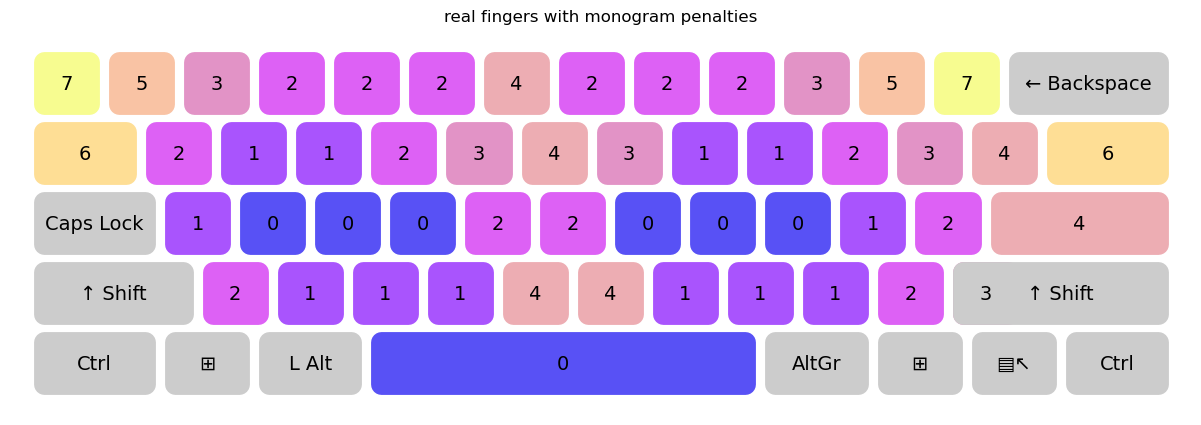

In [17]:
real_kbd.display()

тест40 : 1.26 


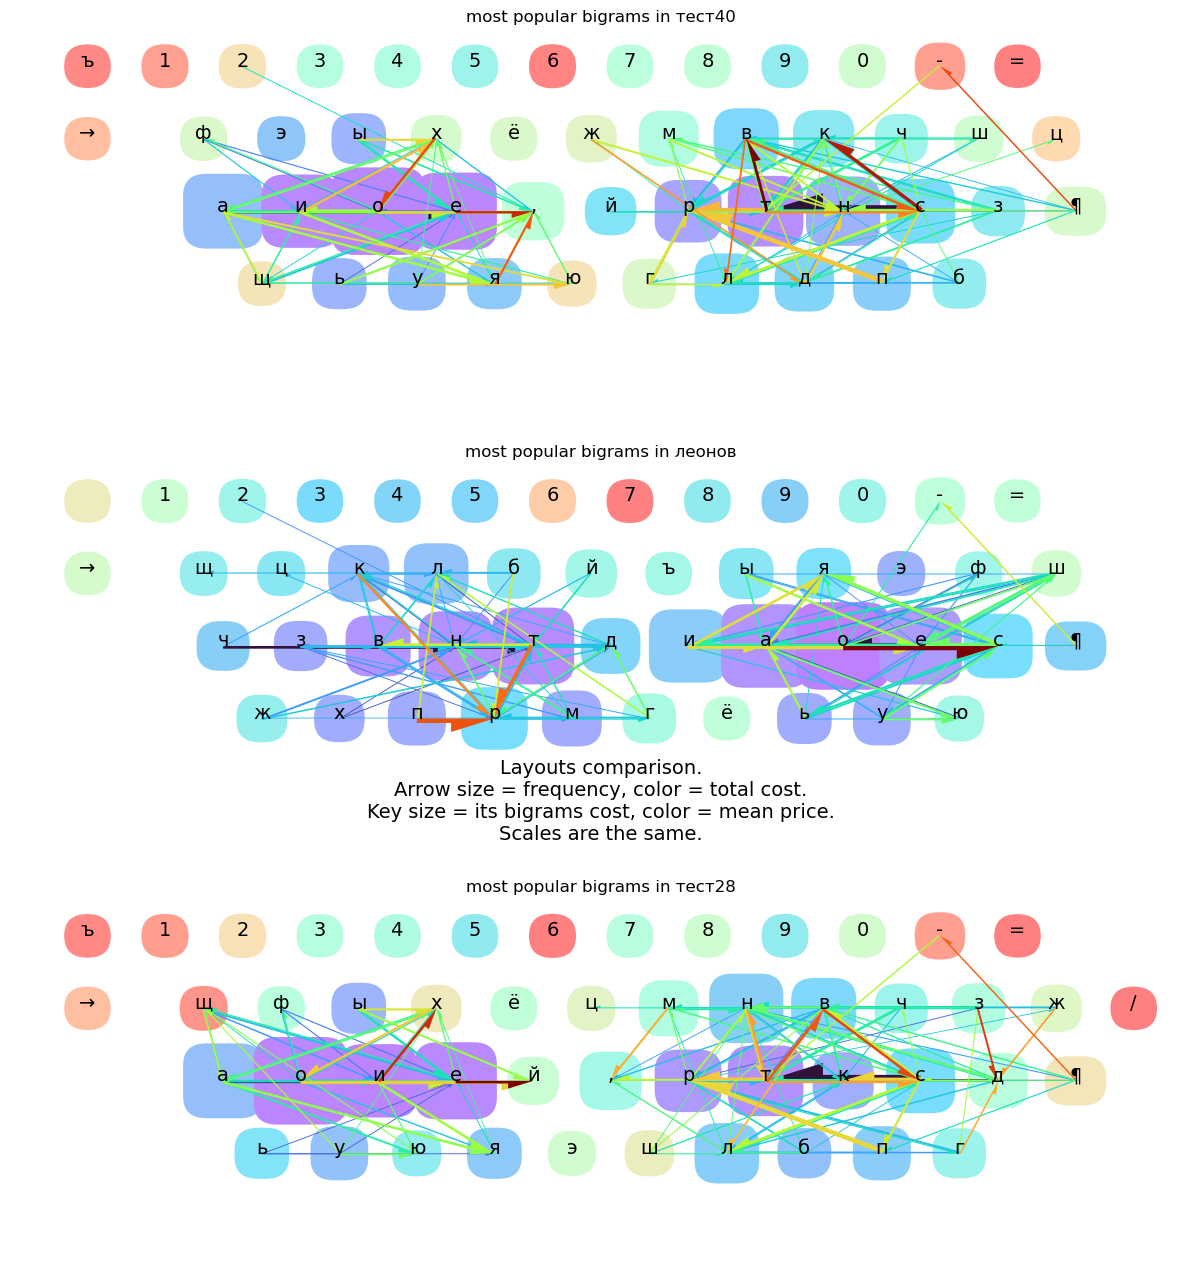

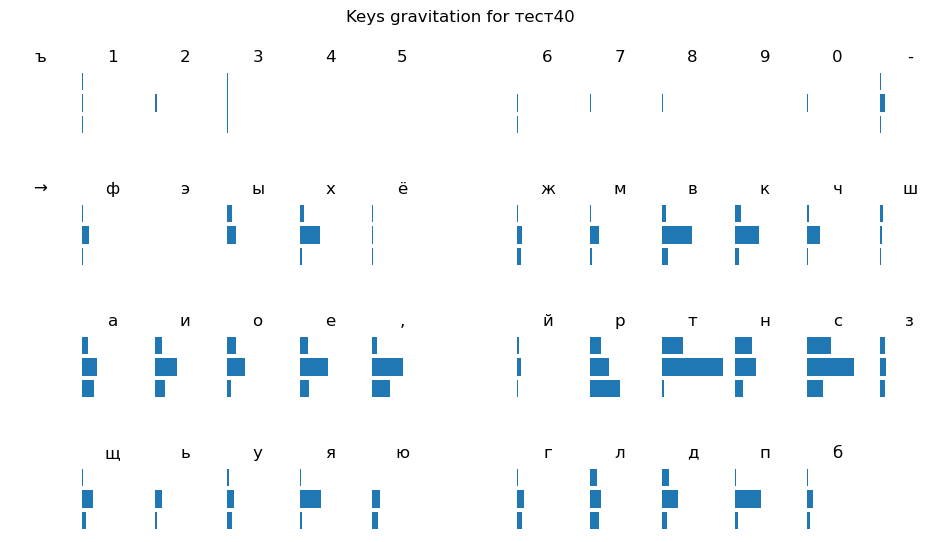

In [19]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест40', (r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

r.combomap(results['леонов'], results['тест28'])
r.display('rows')

check which side and row letters gravitate to in a layout result (this depends on corpus stats, hence it should be done in a Result instance)


# Export Your Or Other Layout to Linux xkb <a name='export-to-xkb'/>

Run the next cell, and it will output layout variant block. You should copy and paste it into some `/usr/share/X11/xkb/symbols/*` file. To show it in layouts, add it to `/usr/share/X11/xkb/rules/evdev.xml`:

```
    <layout>
      <configItem>
        <name>[name of the file in symbols]</name>
        <shortDescription>ru</shortDescription>
        <description>Russian</description>
        <countryList>
          <iso3166Id>RU</iso3166Id>
          <iso3166Id>KZ</iso3166Id>
        </countryList>
        <languageList>
          <iso639Id>rus</iso639Id>
        </languageList>
      </configItem>
      <variantList>
        <variant>
          <configItem>
            <name>[the same name as in xkb_symbols "<name>"]</name>
            <description>[title]</description>
          </configItem>
        </variant>
      </variantList>
    </layout>
```

In [20]:
results['тест39'].layout.export()


	default partial alphanumeric_keys
	xkb_symbols "тест39" {
		include "ru(common)"
		name[Group1]= "Culebron (тест39)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD03> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD04> { [ Cyrillic_ha, Cyrillic_HA ] };
	key <AD05> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_em, Cyrillic_EM ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_ka, Cyrill

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

bigram   num                     category_old  price_old  cost_old  \
272     е,  1459                     altern hands          2      2918   
132     я,  1162                     altern hands          2      2324   
365     е.   905                     altern hands          2      1810   
225     ⌴б  4888                        space bar          1      4888   
350     я.   806                     altern hands          2      1612   
222     йс   467                     altern hands          1       467   
184     ое  1887      in, over 1 finger, same row          0         0   
412     дв   536       in, over 1 finger, adj row          2      1072   
498     зм   567      in, over 1 finger, same row          3      1701   
194     хо  1638             out, over one finger          4      6552   
187     об  3213                     altern hands          1      3213   
181     ой  3205      in, over 1 finger, same row          2      6410   
162     аю  1053       in, over 1 finger, adj row          2      2106   
378     ую  1019  in, adj finger, same or adj row          3      3057   
464     зв   753      in, over 1 finger, same row          1       753   
164     о,  1483                     altern hands          2      2966   
411     дн  1467  in, adj finger, same or adj row          2      2934   
229     лю   960                     altern hands          1       960   
425     ю,   346                     altern hands          2       692   
453     дк   279          pinky -> ring, next row          4      1116   
257     ои   917  in, adj finger, same or adj row          2      1834   
512     др   841      in, over 1 finger, same row          0         0   
196     зн  1644          pinky -> ring, next row          3      4932   
316     ох   389  in, adj finger, same or adj row          4      1556   
664     у,   773                     altern hands          2      1546   
317     о.   764                     altern hands          2      1528   
923     яю   181           index->middle same row          2       362   
516     йч   139                     altern hands          2       278   
359     бс   231             out, over one finger          5      1155   
380     щи   671       in, over 1 finger, adj row          1       671   

                        category_new  price_new  cost_new  delta  
272              same finger adj row          8     11672   8754  
132              same finger adj row          8      9296   6972  
365              same finger adj row          8      7240   5430  
225                        space bar          2      9776   4888  
350              same finger adj row          8      6448   4836  
222                    pinky adj row         11      5137   4670  
184  in, adj finger, same or adj row          2      3774   3774  
412             same finger over row          9      4824   3752  
498              same finger adj row          9      5103   3402  
194              same finger adj row          6      9828   3276  
187                     altern hands          2      6426   3213  
181                     altern hands          3      9615   3205  
162       in, over 1 finger, adj row          5      5265   3159  
378  in, adj finger, same or adj row          6      6114   3057  
464             out, over one finger          5      3765   3012  
164  in, adj finger, same or adj row          4      5932   2966  
411             out, over one finger          4      5868   2934  
229                     altern hands          4      3840   2880  
425              same finger adj row          8      2768   2076  
453              adj finger over row         11      3069   1953  
257             out, over one finger          4      3668   1834  
512  in, adj finger, same or adj row          2      1682   1682  
196             out, over one finger          4      6576   1644  
316              same finger adj row          8      3112   1556  
664  in, adj finger, same or adj r

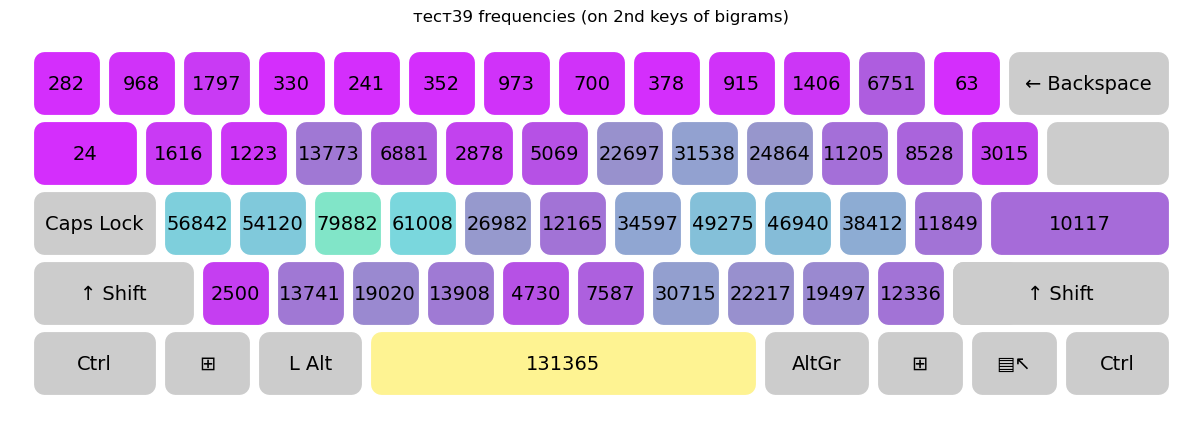

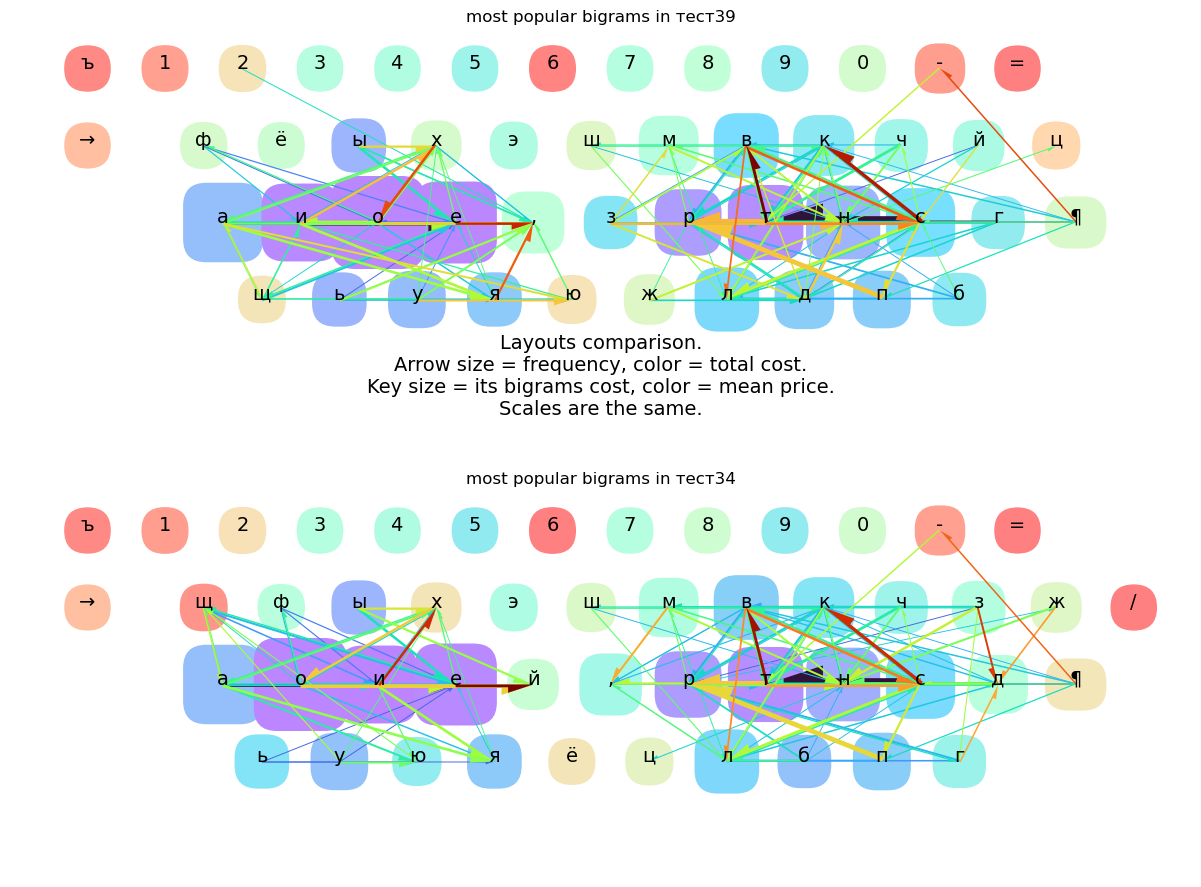

In [21]:
results['тест39'].display('num')
results['тест39'].combomap(results['тест34'])
results['тест34'].compare(results['тест39']).sort_values('delta', ascending=False).head(30)

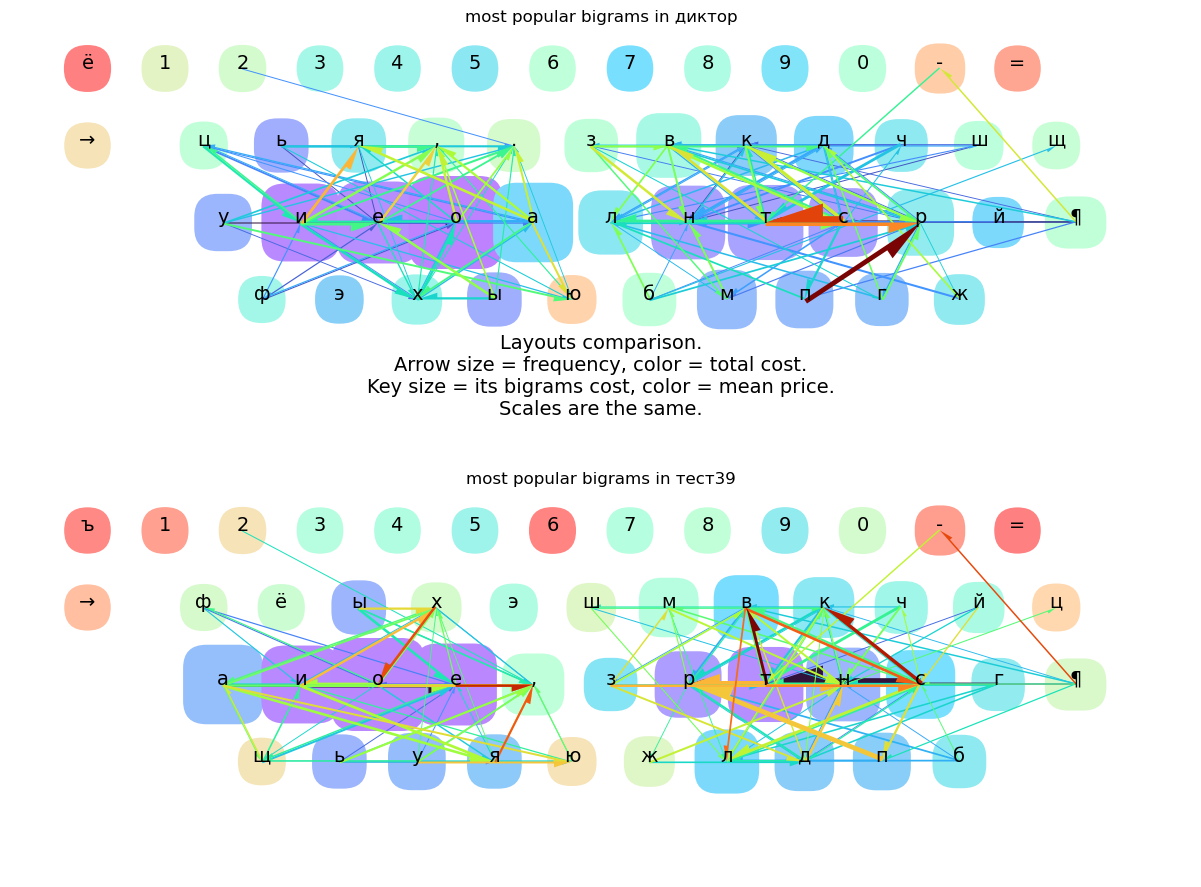

In [22]:
results['диктор'].combomap(results['тест39'])

## Losses

In [23]:
compare(results, 'тест34', 'тест39').head(30)

bigram   num                     category_old  price_old  cost_old  \
272     е,  1459                     altern hands          2      2918   
132     я,  1162                     altern hands          2      2324   
365     е.   905                     altern hands          2      1810   
225     ⌴б  4888                        space bar          1      4888   
350     я.   806                     altern hands          2      1612   
222     йс   467                     altern hands          1       467   
184     ое  1887      in, over 1 finger, same row          0         0   
412     дв   536       in, over 1 finger, adj row          2      1072   
498     зм   567      in, over 1 finger, same row          3      1701   
194     хо  1638             out, over one finger          4      6552   
187     об  3213                     altern hands          1      3213   
181     ой  3205      in, over 1 finger, same row          2      6410   
162     аю  1053       in, over 1 finger, adj row          2      2106   
378     ую  1019  in, adj finger, same or adj row          3      3057   
464     зв   753      in, over 1 finger, same row          1       753   
164     о,  1483                     altern hands          2      2966   
411     дн  1467  in, adj finger, same or adj row          2      2934   
229     лю   960                     altern hands          1       960   
425     ю,   346                     altern hands          2       692   
453     дк   279          pinky -> ring, next row          4      1116   
257     ои   917  in, adj finger, same or adj row          2      1834   
512     др   841      in, over 1 finger, same row          0         0   
196     зн  1644          pinky -> ring, next row          3      4932   
316     ох   389  in, adj finger, same or adj row          4      1556   
664     у,   773                     altern hands          2      1546   
317     о.   764                     altern hands          2      1528   
923     яю   181           index->middle same row          2       362   
516     йч   139                     altern hands          2       278   
359     бс   231             out, over one finger          5      1155   
380     щи   671       in, over 1 finger, adj row          1       671   

                        category_new  price_new  cost_new  delta  
272              same finger adj row          8     11672   8754  
132              same finger adj row          8      9296   6972  
365              same finger adj row          8      7240   5430  
225                        space bar          2      9776   4888  
350              same finger adj row          8      6448   4836  
222                    pinky adj row         11      5137   4670  
184  in, adj finger, same or adj row          2      3774   3774  
412             same finger over row          9      4824   3752  
498              same finger adj row          9      5103   3402  
194              same finger adj row          6      9828   3276  
187                     altern hands          2      6426   3213  
181                     altern hands          3      9615   3205  
162       in, over 1 finger, adj row          5      5265   3159  
378  in, adj finger, same or adj row          6      6114   3057  
464             out, over one finger          5      3765   3012  
164  in, adj finger, same or adj row          4      5932   2966  
411             out, over one finger          4      5868   2934  
229                     altern hands          4      3840   2880  
425              same finger adj row          8      2768   2076  
453              adj finger over row         11      3069   1953  
257             out, over one finger          4      3668   1834  
512  in, adj finger, same or adj row          2      1682   1682  
196             out, over one finger          4      6576   1644  
316              same finger adj row          8      3112   1556  
664  in, adj finger, same or adj r

## Gains

In [24]:
compare(results, 'тест34', 'тест39').tail(30)

bigram   num                     category_old  price_old  cost_old  \
172     уд  1569                     altern hands          2      3138   
346     бл   789  in, adj finger, same or adj row          3      2367   
819     л.   279              same finger adj row          8      2232   
167     ад  1679                     altern hands          2      3358   
267     р,   294              same finger adj row          8      2352   
685     ¶д   192                    pinky adj row         12      2304   
379     ющ   332        over 1 finger, over 1 row         10      3320   
416     л,   349              same finger adj row          8      2792   
331     ущ   350              adj finger over row         12      4200   
716     сд   210                    pinky adj row         12      2520   
248     ед  2227                     altern hands          2      4454   
64      из  2251                     altern hands          3      6753   
250     дс   382                    pinky adj row         11      4202   
179     т,  1153  in, adj finger, same or adj row          4      4612   
116     аз  2695                     altern hands          3      8085   
931     зг   281                   pinky over row         14      3934   
424     м.   538              same finger adj row          8      4304   
94      ⌴з  3466                        space bar          3     10398   
46      ль  4283                     altern hands          2      8566   
155     ие  2374  in, adj finger, same or adj row          2      4748   
195     од  4816                     altern hands          2      9632   
38      ть  5581                     altern hands          2     11162   
192     м,   964              same finger adj row          8      7712   
227     ⌴д  5792                        space bar          2     11584   
111     их  1574              same finger adj row          8     12592   
301     гд   645                    pinky adj row         12      7740   
447     зд   979                    pinky adj row         12     11748   
360     жд   691                    pinky adj row         12      8292   
177     .¶  3921                   index -> pinky          6     23526   
296     ей  2009              same finger adj row          8     16072   

                        category_new  price_new  cost_new  delta  
172                     altern hands          1      1569  -1569  
346      in, over 1 finger, same row          1       789  -1578  
819                     altern hands          2       558  -1674  
167                     altern hands          1      1679  -1679  
267                     altern hands          2       588  -1764  
685       in, over 1 finger, adj row          2       384  -1920  
379                   index -> pinky          4      1328  -1992  
416                     altern hands          2       698  -2094  
331             out, over one finger          6      2100  -2100  
716       in, over 1 finger, adj row          2       420  -2100  
248                     altern hands          1      2227  -2227  
64                      altern hands          2      4502  -2251  
250             out, over one finger          5      1910  -2292  
179                     altern hands          2      2306  -2306  
116                     altern hands          2      5390  -2695  
931                   index -> pinky          4      1124  -2810  
424                     altern hands          2      1076  -3228  
94                         space bar          2      6932  -3466  
46                      altern hands          1      4283  -4283  
155      in, over 1 finger, same row          0         0  -4748  
195                     altern hands          1      4816  -4816  
38                      altern hands          1      5581  -5581  
192                     altern hands          2      1928  -5784  
227                        space bar          1      5792  -5792  
111  in, adj finger, same or adj r

You can save the comparison table to CSV:

In [25]:
compare(results, 'леонов', 'тест39').to_csv('leonov-test39.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [26]:
results['тест39'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  price_l2  price_di  \
53      ¶¶   4802  ¶  ¶  -  -  0.005266         4         0   
25      ⌴м   5232  ⌴  м  -  c  0.005737         3         0   
177     .¶   3921  .  ¶  -  -  0.004300         4         0   
49      тв   2081  т  в  c  c  0.002282         1         6   
40      ⌴п  13192  ⌴  п  -  c  0.014466         1         0   
114     ск   3125  с  к  c  c  0.003427         1         3   
191     ом   4114  о  м  v  c  0.004511         3         0   
127     ⌴с  11948  ⌴  с  -  c  0.013102         1         0   
272     е,   1459  е  ,  v  -  0.001600         2         6   
18      ⌴в  11347  ⌴  в  -  c  0.012443         1         0   
124     ⌴-   2268  ⌴  -  -  -  0.002487         5         0   
125     --   2097  -  -  -  -  0.002300         5         0   
802     ¶-    586  ¶  -  -  -  0.000643         5        12   
102     ем   3307  е  м  v  c  0.003626         3         0   
194     хо   1638  х  о  c  v  0.001796         0         6   
225     ⌴б   4888  ⌴  б  -  c  0.005360         2         0   
181     ой   3205  о  й  v  c  0.003515         3         0   
132     я,   1162  я  ,  v  -  0.001274         2         6   
465     вс   1832  в  с  c  c  0.002009         1         4   
338     вл    794  в  л  c  c  0.000871         1        10   
130     тс   1614  т  с  c  c  0.001770         1         4   
105     на   8003  н  а  c  v  0.008776         1         0   
106     им   2603  и  м  v  c  0.002854         3         0   
133     ⌴ч   3827  ⌴  ч  -  c  0.004197         2         0   
10      ра   7597  р  а  c  v  0.008331         1         0   
2       ож   1890  о  ж  v  c  0.002073         4         0   
182     ⌴э   2440  ⌴  э  -  v  0.002676         3         0   
365     е.    905  е  .  v  -  0.000992         2         6   
299     ам   2406  а  м  v  c  0.002638         3         0   
94      ⌴з   3466  ⌴  з  -  c  0.003801         2         0   

                    category  price   cost  finger  column  row   h1   h2  
53                  same key      4  19208     9.0    13.0  2.0  1.0  1.0  
25                 space bar      3  15696     6.0     8.0  1.0  0.0  1.0  
177             altern hands      4  15684     9.0    13.0  2.0  0.0  1.0  
49       same finger adj row      7  14567     7.0     9.0  1.0  1.0  1.0  
40                 space bar      1  13192     8.0    10.0  3.0  0.0  1.0  
114  pinky -> ring, next row      4  12500     8.0    10.0  1.0  1.0  1.0  
191             altern hands      3  12342     6.0     8.0  1.0  0.0  1.0  
127                space bar      1  11948     9.0    11.0  2.0  0.0  1.0  
272      same finger adj row      8  11672     3.0     5.0  2.0  0.0  0.0  
18                 space bar      1  11347     7.0     9.0  1.0  0.0  1.0  
124                space bar      5  11340     9.0    12.0  0.0  0.0  1.0  
125                 same key      5  10485     9.0    12.0  0.0  1.0  1.0  
802           pinky over row     17   9962     9.0    12.0  0.0  1.0  1.0  
102             altern hands      3   9921     6.0     8.0  1.0  0.0  1.0  
194      same finger adj row      6   9828     2.0     3.0  2.0  0.0  0.0  
225                space bar      2   9776     9.0    11.0  3.0  0.0  1.0  
181             altern hands      3   9615     9.0    12.0  1.0  0.0  1.0  
132      same finger adj row      8   9296     3.0     5.0  2.0  0.0  0.0  
465     out, over one finger      5   9160     9.0    11.0  2.0  1.0  1.0  
338      adj finger over row     11   8734     6.0     8.0  3.0  1.0  1.0  
130     out, over one finger      5   8070     9.0    11.0  2.0  1.0  1.0  
105             altern hands      1   8003     0.0     1.0  2.0  1.0  0.0  
106             altern hands      3   7809     6.0     8.0  1.0  0.0  1.0  
133                space bar      2   7654     9.0    11.0  1.0  0.0  1.0  
10              altern hands      1   7597     0.0     1.0  2.0  1.0  0.0  
2               altern hands      4   7560     6.0     7.0  3.0  0.0  1.0 

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [27]:
key = 'тест39' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [28]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count  finger  ftype  hand  penalty
ъ      0    0       0          1       0      4     0        7
1      0    0       1          1       0      4     0        5
2      0    0       2          1       0      4     0        3
3      0    0       3          1       0      4     0        2
4      0    0       4          1       1      3     0        2
5      0    0       5          1       2      2     0        2
6      0    0       7          1       3      1     0        4
7      0    0       8          1       6      1     1        2
8      0    0       9          1       7      2     1        2
9      0    0      10          1       8      3     1        2
0      0    0      11          1       9      4     1        3
-      0    0      12          1       9      4     1        5
=      0    0      13          1       9      4     1        7
→      0    1       0          1       0      4     0        6
ф      0    1       1          1       0      4     0        2
э      0    1       2          1       0      4     0        1
ы      0    1       3          1       1      3     0        1
х      0    1       4          1       2      2     0        2
ё      0    1       5          1       3      1     0        3
ж      0    1       7          1       6      1     1        4
м      0    1       8          1       6      1     1        3
в      0    1       9          1       7      2     1        1
к      0    1      10          1       8      3     1        1
ч      0    1      11          1       9      4     1        2
ш      0    1      12          1       9      4     1        3
ц      0    1      13          1       9      4     1        4
а      0    2       1          1       0      4     0        1
и      0    2       2          1       1      3     0        0
о      0    2       3          1       2      2     0        0
е      0    2       4          1       3      1     0        0
,      0    2       5          1       3      1     0        2
й      0    2       7          1       6      1     1        2
р      0    2       8          1       6      1     1        0
т      0    2       9          1       7      2     1        0
н      0    2      10          1       8      3     1        0
с      0    2      11          1       9      4     1        1
з      0    2      12          1       9      4     1        2
¶      0    2      13          1       9      4     1        4
щ      0    3       1          1       0      4     0        2
ь      0    3       2          1       1      3     0        1
у      0    3       3          1       2      2     0        1
я      0    3       4          1       3      1     0        1
ю      0    3       5          1       3      1     0        4
г      0    3       7          1       6      1     1        4
л      0    3       8          1       6      1     1        1
д      0    3       9          1       7      2     1        1
п      0    3      10          1       8      3     1        1
б      0    3      11          1       9      4     1        2
⌴      0    4       0          1       4      0     0        0
\      1    0       0          1       0      4     0        7
!      1    0       1          1       0      4     0        5
"      1    0       2          1       0      4     0        3
№      1    0       3          1       0      4     0        2
;      1    0       4          1       1      3     0        2
%      1    0       5          1       2      2     0        2
:      1    0       7          1       3      1     0        4
?      1    0       8          1       6      1     1        2
*      1    0       9          1       7      2     1        2
(      1    0      10          1       8      3     1        2
)      1    0      11          1       9      4     1        3
_      1    0      12          1       9      4     1        5
+      1    0      13          1       9      4     1        7
.      1    2       5          1  

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor, and is omitted.

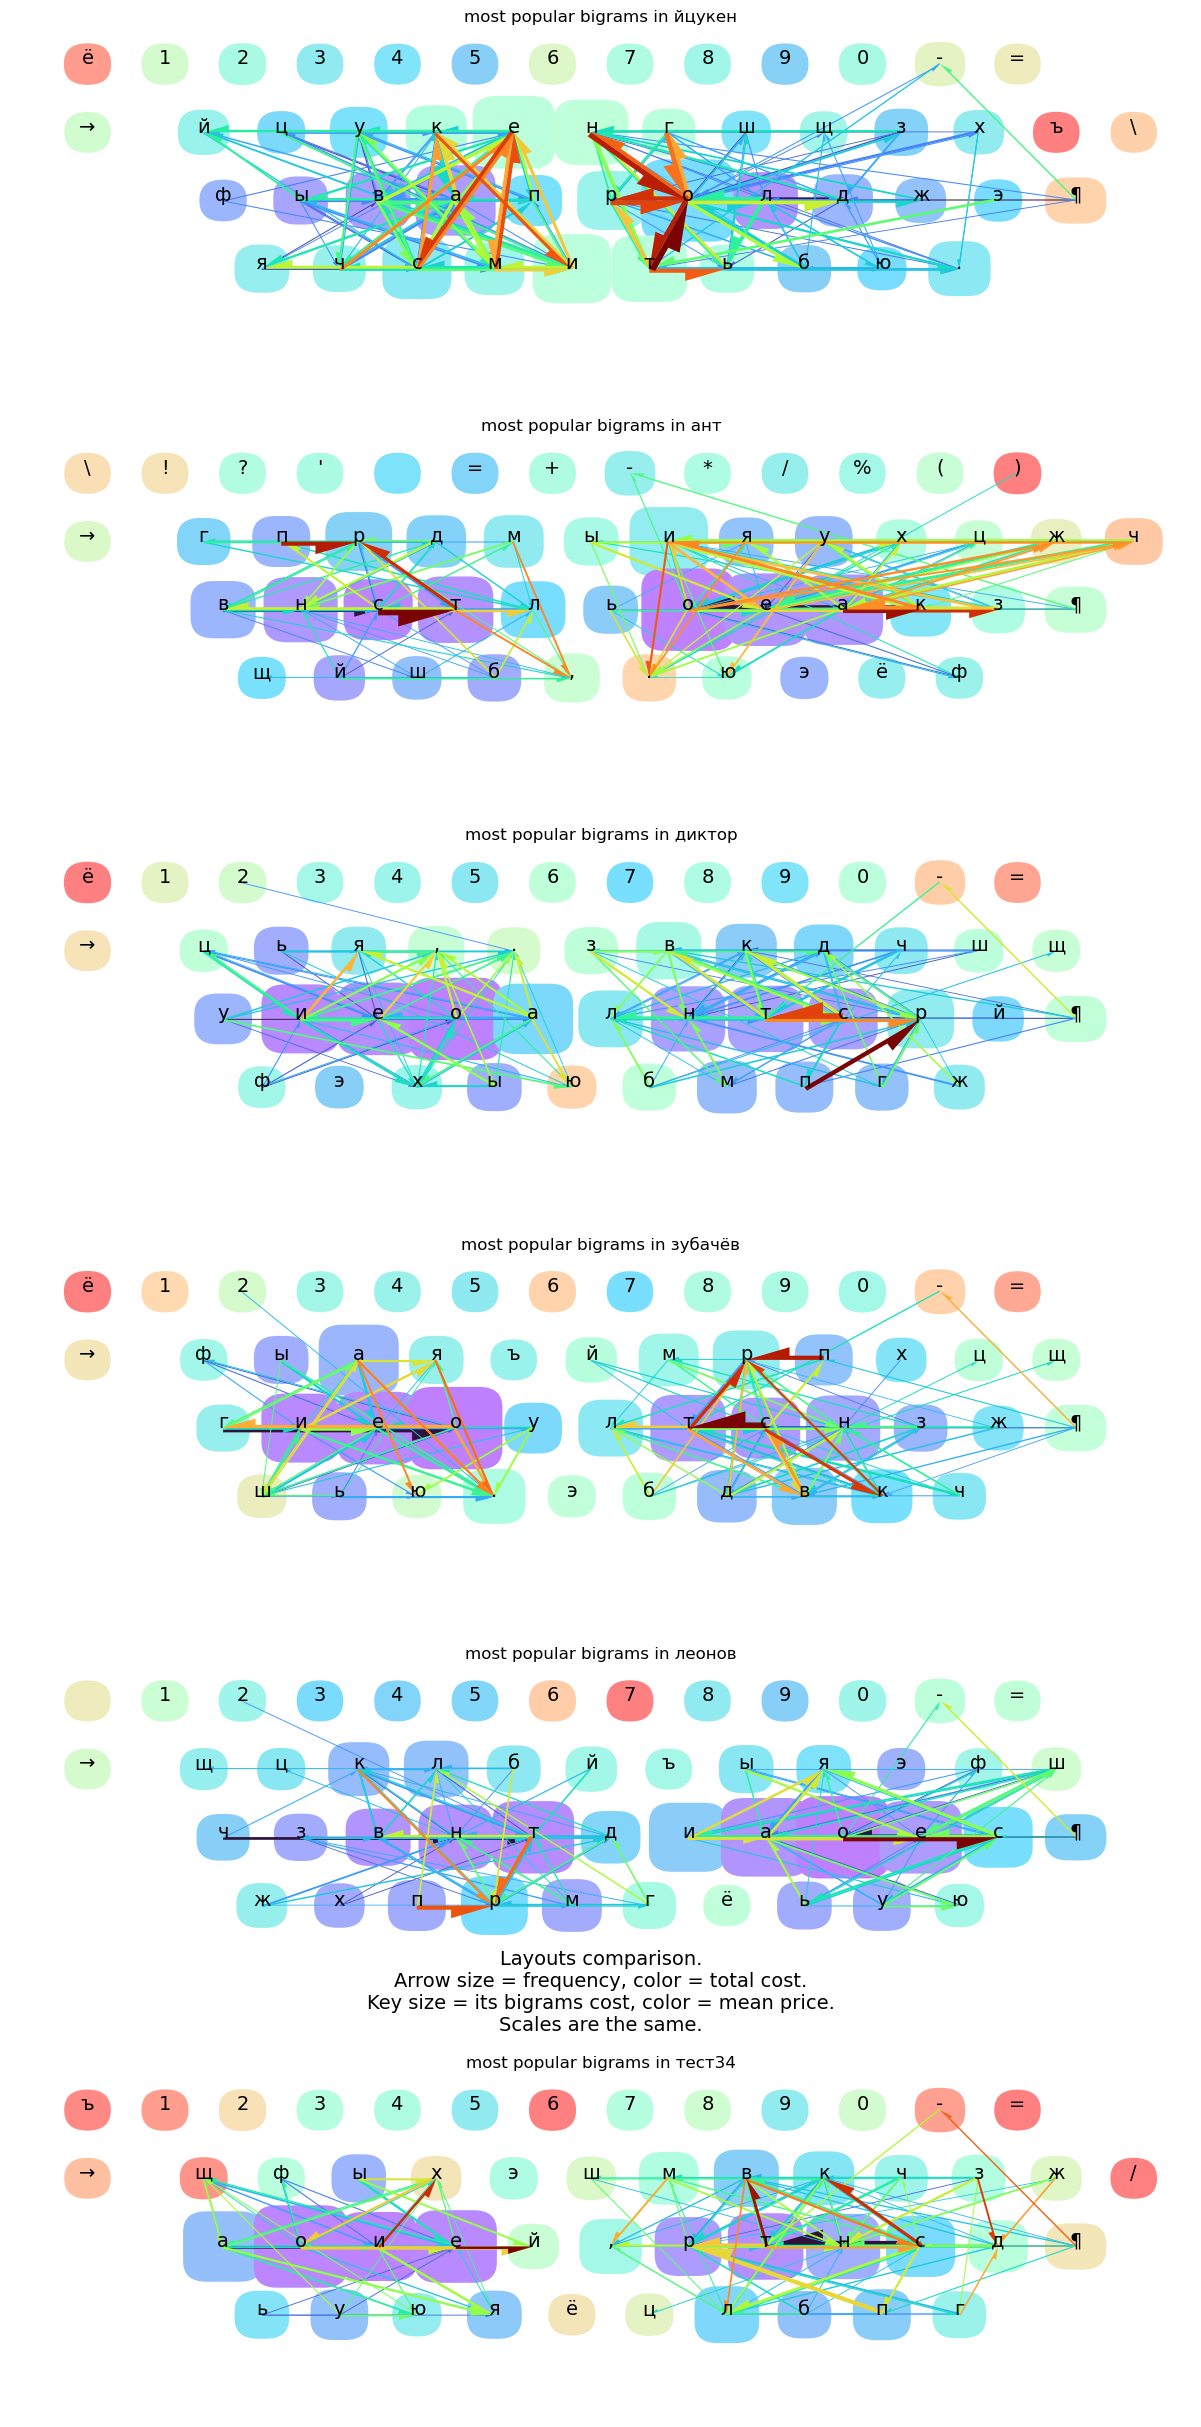

In [29]:
rs = results
rs['йцукен'].combomap(rs['ант'], rs['диктор'], rs['зубачёв'], rs['леонов'], rs['тест34'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

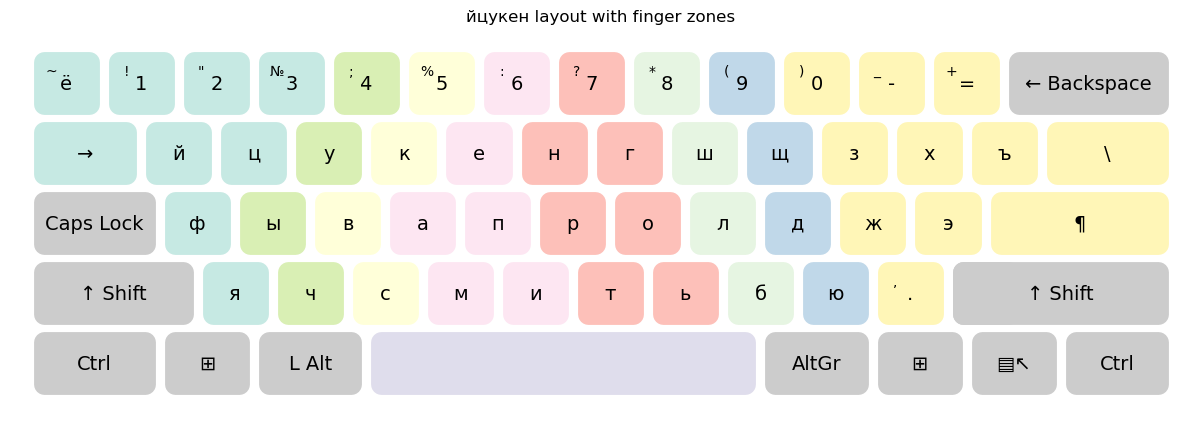

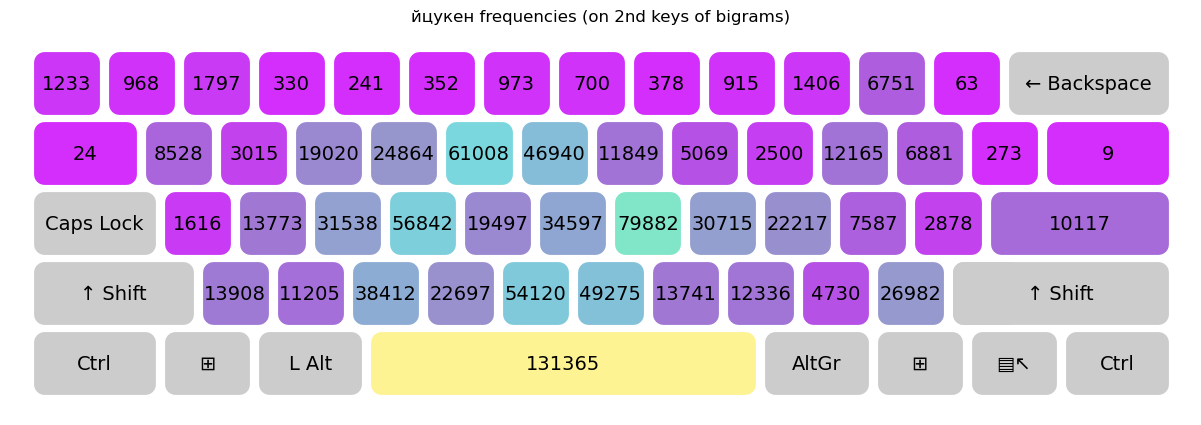

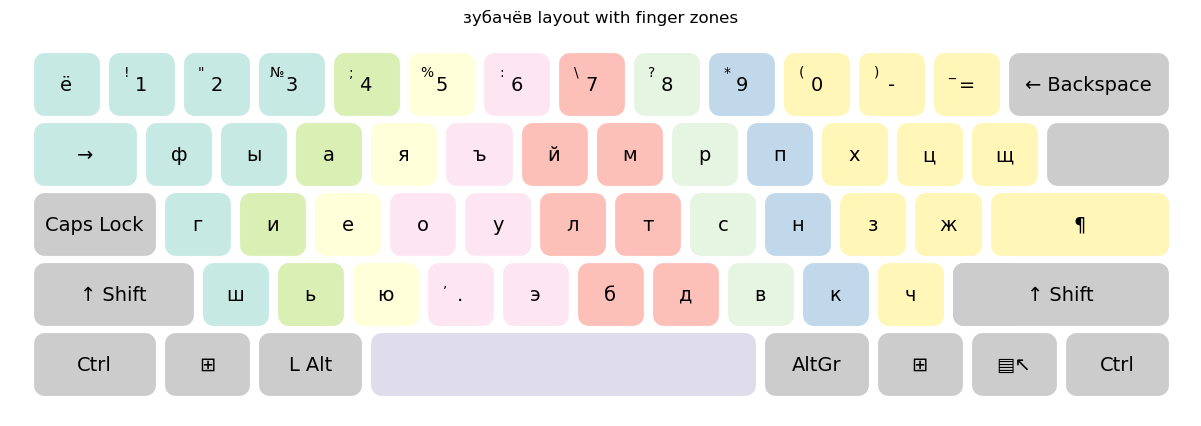

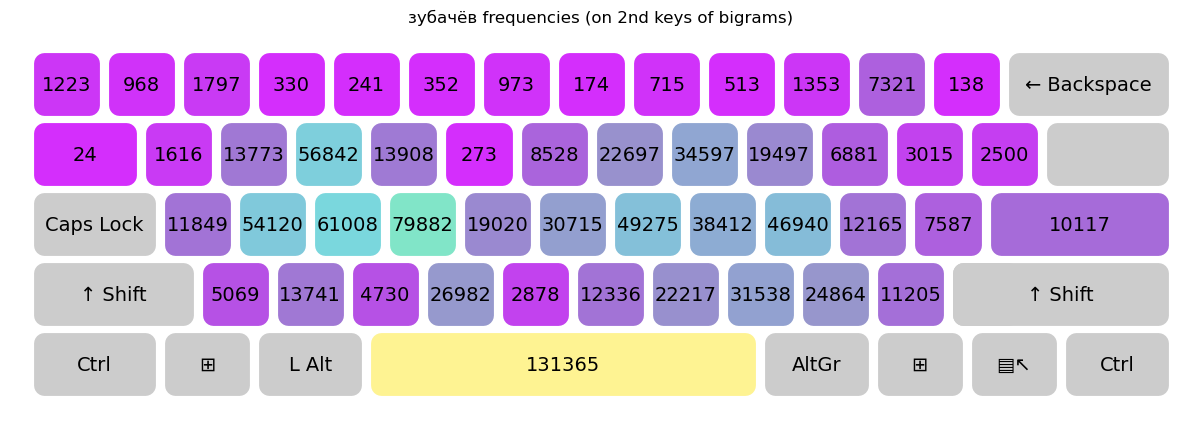

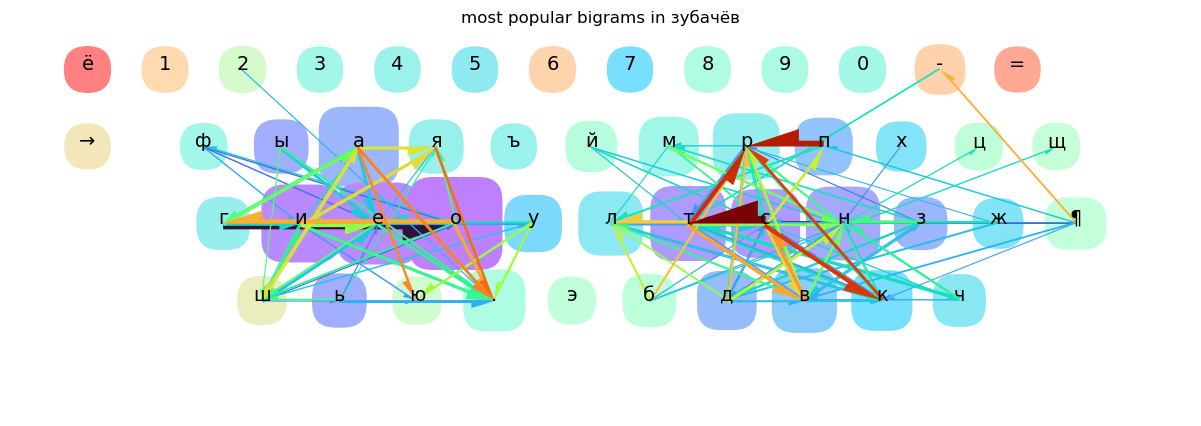

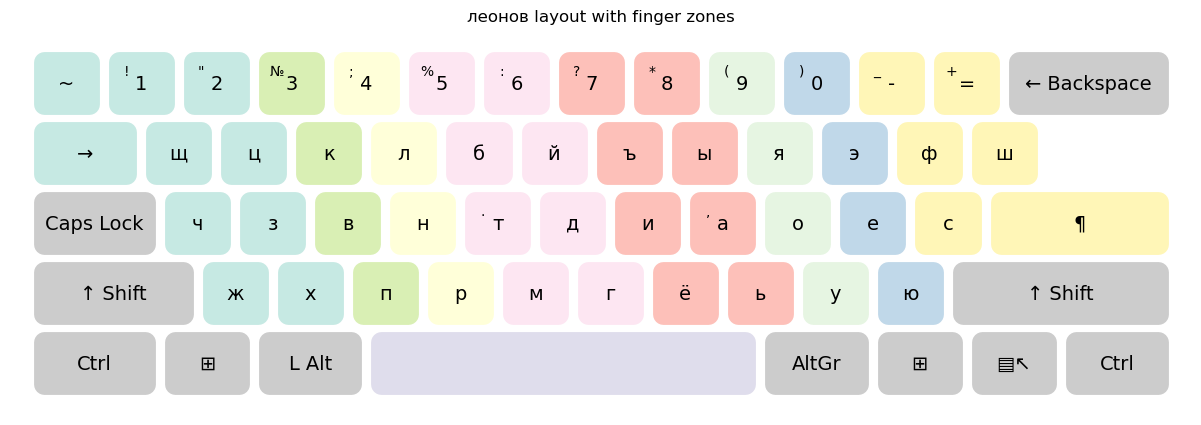

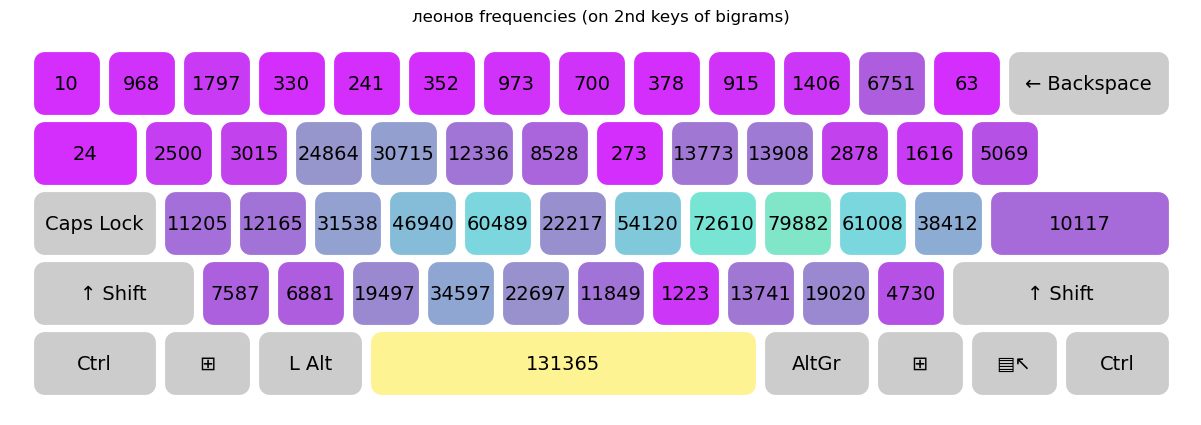

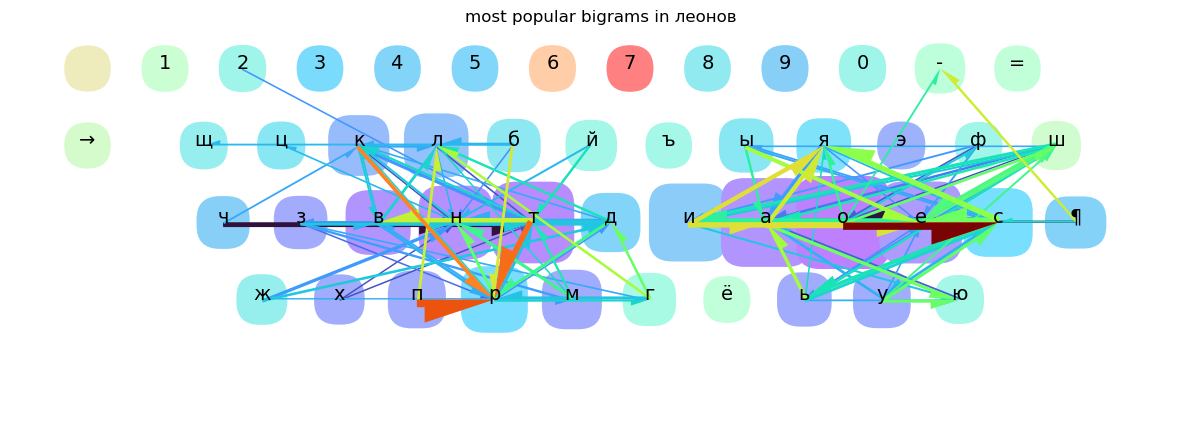

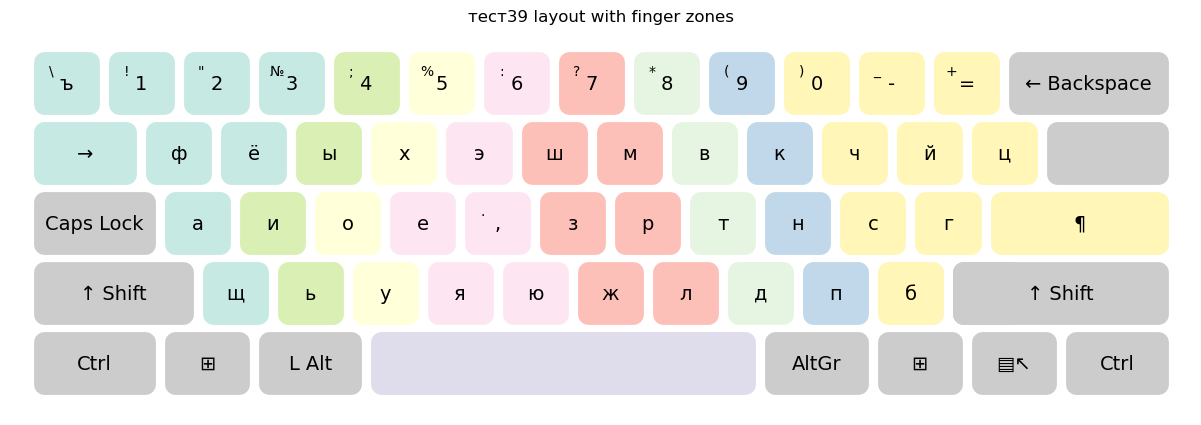

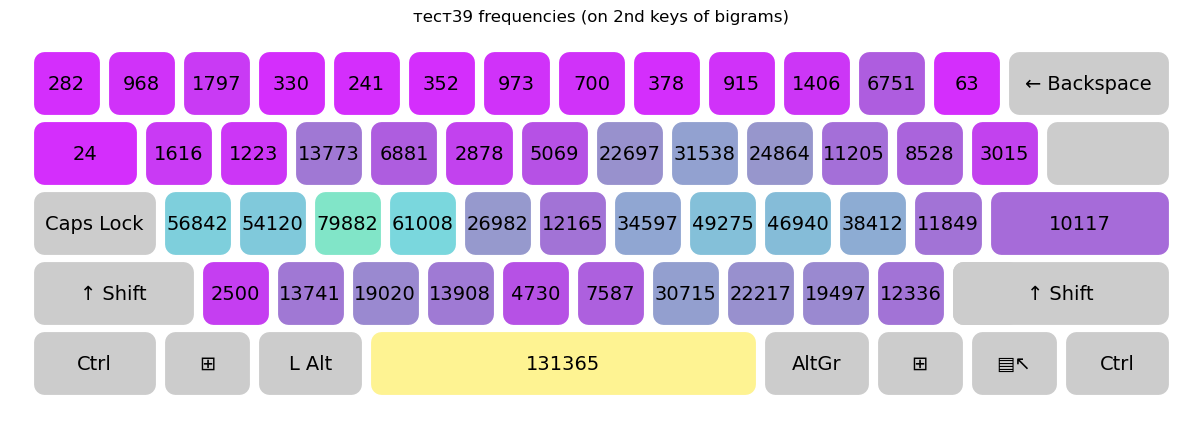

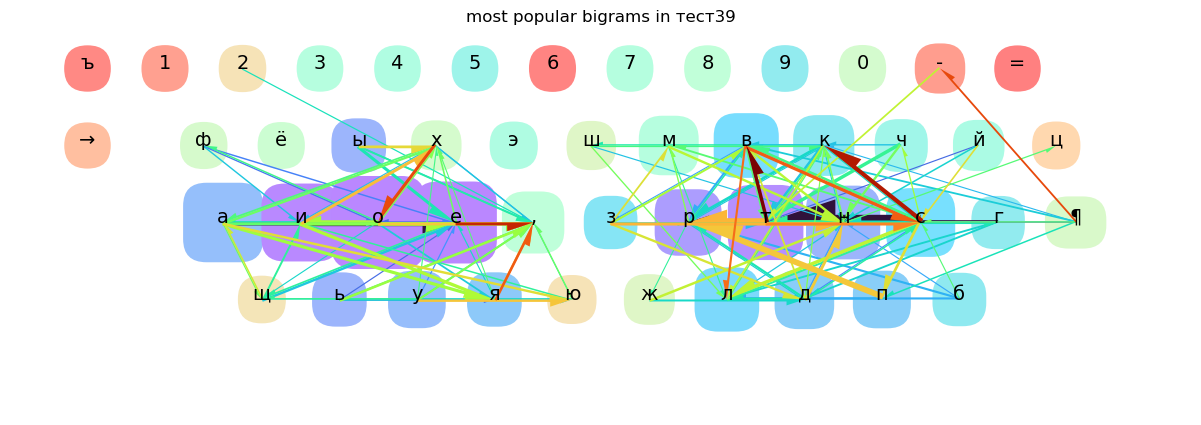

In [30]:
results['йцукен'].display('layout', 'num')
results['зубачёв'].display('layout', 'num', 'arrows')
results['леонов'].display('layout', 'num', 'arrows')
results['тест39'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [31]:
cmp = compare(results, 'леонов', 'тест39')
cmp.head(30)

bigram    num                     category_old  price_old  cost_old  \
272     е,   1459      in, over 1 finger, same row          0         0   
18      ⌴в  11347                        space bar          0         0   
25      ⌴м   5232                        space bar          1      5232   
194     хо   1638                     altern hands          0         0   
53      ¶¶   4802                         same key          2      9604   
114     ск   3125                     altern hands          1      3125   
191     ом   4114                     altern hands          1      4114   
132     я,   1162                    in, lower row          1      1162   
105     на   8003                     altern hands          0         0   
177     .¶   3921                     altern hands          2      7842   
10      ра   7597                     altern hands          0         0   
465     вс   1832                     altern hands          1      1832   
365     е.    905                     altern hands          0         0   
35      ов   6667                     altern hands          0         0   
102     ем   3307                     altern hands          1      3307   
196     зн   1644      in, over 1 finger, same row          0         0   
130     тс   1614                     altern hands          1      1614   
350     я.    806                     altern hands          0         0   
338     вл    794  in, adj finger, same or adj row          3      2382   
49      тв   2081             out, over one finger          4      8324   
115     ка   5674                     altern hands          0         0   
106     им   2603                     altern hands          1      2603   
92      та   4987                     altern hands          0         0   
36      ва   4893                     altern hands          0         0   
182     ⌴э   2440                        space bar          1      2440   
299     ам   2406                     altern hands          1      2406   
111     их   1574                     altern hands          1      1574   
222     йс    467                     altern hands          1       467   
916     ща    415                     altern hands          0         0   
124     ⌴-   2268                        space bar          3      6804   

                        category_new  price_new  cost_new  delta  
272              same finger adj row          8     11672  11672  
18                         space bar          1     11347  11347  
25                         space bar          3     15696  10464  
194              same finger adj row          6      9828   9828  
53                          same key          4     19208   9604  
114          pinky -> ring, next row          4     12500   9375  
191                     altern hands          3     12342   8228  
132              same finger adj row          8      9296   8134  
105                     altern hands          1      8003   8003  
177                     altern hands          4     15684   7842  
10                      altern hands          1      7597   7597  
465             out, over one finger          5      9160   7328  
365              same finger adj row          8      7240   7240  
35                      altern hands          1      6667   6667  
102                     altern hands          3      9921   6614  
196             out, over one finger          4      6576   6576  
130             out, over one finger          5      8070   6456  
350              same finger adj row          8      6448   6448  
338              adj finger over row         11      8734   6352  
49               same finger adj row          7     14567   6243  
115                     altern hands          1      5674   5674  
106                     altern hands          3      7809   5206  
92                      altern hands          1      4987   4987  
36                      altern hands          1      4893   4893  
182

In [32]:
cmp.tail(30)

bigram   num                     category_old  price_old  cost_old  \
225     ⌴б  4888                        space bar          3     14664   
156     ис  2458                   index -> pinky          3      7374   
256     ые  1696             out, over one finger          4      6784   
404     се  2649  in, adj finger, same or adj row          2      5298   
190     а,  1328              same finger adj row          6      7968   
277     ая  1782             out, over one finger          5      8910   
110     ки  2886                     altern hands          2      5772   
227     ⌴д  5792                        space bar          2     11584   
491     гл   645              adj finger over row         11      7095   
262     ия  1949             out, over one finger          5      9745   
69      ор  5921                     altern hands          1      5921   
129     ае  1585             out, over one finger          4      6340   
300     и,  1600              same finger adj row          6      9600   
79      ⌴г  3298                        space bar          4     13192   
238     ас  3302                   index -> pinky          3      9906   
153     ог  3341                     altern hands          4     13364   
33      ти  3904                     altern hands          2      7808   
252     пл   786              adj finger over row         11      8646   
236     ны  3979                     altern hands          3     11937   
324     бр   812              adj finger over row         11      8932   
28      ри  4244                     altern hands          2      8488   
155     ие  2374             out, over one finger          4      9496   
78      тр  3288             out, over one finger          5     16440   
7       ли  5507                     altern hands          2     11014   
41      пр  6010  in, adj finger, same or adj row          3     18030   
31      кр  1386              adj finger over row         11     15246   
15      ни  7156                     altern hands          2     14312   
61      ес  4129             out, over one finger          5     20645   
23      ⌴и  9284                        space bar          2     18568   
56      ос  5489             out, over one finger          5     27445   

                        category_new  price_new  cost_new  delta  
225                        space bar          2      9776  -4888  
156                     altern hands          1      2458  -4916  
256       in, over 1 finger, adj row          1      1696  -5088  
404                     altern hands          0         0  -5298  
190      in, over 1 finger, same row          2      2656  -5312  
277       in, over 1 finger, adj row          2      3564  -5346  
110                     altern hands          0         0  -5772  
227                        space bar          1      5792  -5792  
491       in, over 1 finger, adj row          2      1290  -5805  
262       in, over 1 finger, adj row          2      3898  -5847  
69                      altern hands          0         0  -5921  
129      in, over 1 finger, same row          0         0  -6340  
300      in, over 1 finger, same row          2      3200  -6400  
79                         space bar          2      6596  -6596  
238                     altern hands          1      3302  -6604  
153                     altern hands          2      6682  -6682  
33                      altern hands          0         0  -7808  
252      in, over 1 finger, same row          1       786  -7860  
236                     altern hands          1      3979  -7958  
324       in, over 1 finger, adj row          1       812  -8120  
28                      altern hands          0         0  -8488  
155      in, over 1 finger, same row          0         0  -9496  
78   in, adj finger, same or adj row          2      6576  -9864  
7                       altern hands          0         0 -11014  
41        in, over 1 finger, adj r